# **Assignment3**

**NAME:I SAI PRADEEP**\
**ROLL No.:AI21BTECH11013**

**QUESTION-1**
>A)

In [1]:
import torch
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms
from PIL import Image
from torch import nn
import torch
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms
from PIL import Image
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# resnet1 => a variable representing resnet50, with default weights
resnet1 = resnet50(weights=ResNet50_Weights.DEFAULT)


# A function for preprocessing the image 'img'
def PreprocessIt2(img):
    preprocess = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    i1_new = preprocess(img)
    i1_new = i1_new.unsqueeze(0)
    return i1_new

# getClassIndex is a function which takes the output classification label scores 
# Returns the model(resnet50 here) predicted label
def getClassIndex(array):
    label=0
    for i in range(0,1000):
        if(array[i]>array[label]):
            label=i
    return label

# VanillaBP is a function that takes image and model as inputs, does the vanilla Back Propagation
# Also plots the input image and the output of Vanilla Back Propagation using subplot
def VanillaBP(i1,model):
    # here we are making the required_grad of parameters in the model (model.parameters() contains all the parameters) as False
    # Because in Vanilla Back propagation, we are intrested in relation between input image and the output,
    # so we neglect doing backpropagation and updating the weights
    for param in model.parameters():
        param.requires_grad = False
    # evaluate the model
    model.eval()
    # preprocess the given image 'i1'
    img=PreprocessIt2(i1)
    img.requires_grad = True
    # output of the model with image input 'img'
    output = model(img)
    label=getClassIndex(output[0])
    # P => a np array which has value 1 at index label and 0 at other indices
    P=np.zeros(1000)
    P[label] = 1
    P=torch.from_numpy(P)
    
    model.zero_grad()
    output[0].backward(gradient=P)
    
    grads=img.grad
    grads=grads.reshape((3,224,224))
    grads=grads-torch.min(grads)/(torch.max(grads)-torch.min(grads))
    grads=grads.numpy()
    grads=grads.transpose((1,2,0))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(i1)
    plt.subplot(1, 2, 2)
    plt.imshow(grads)


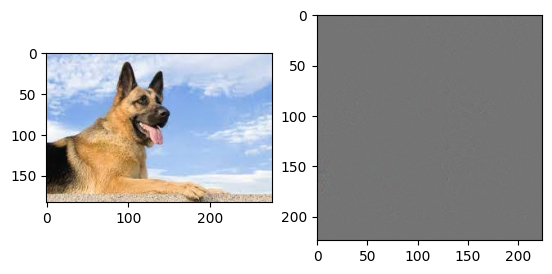

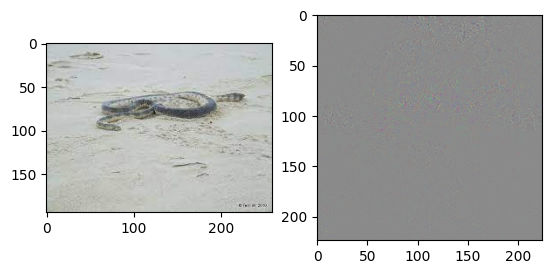

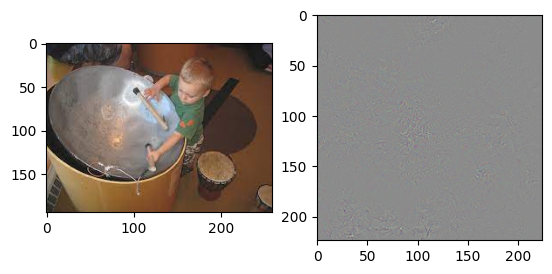

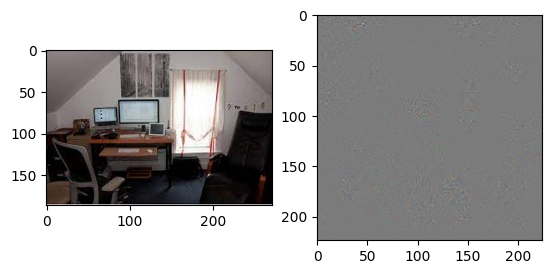

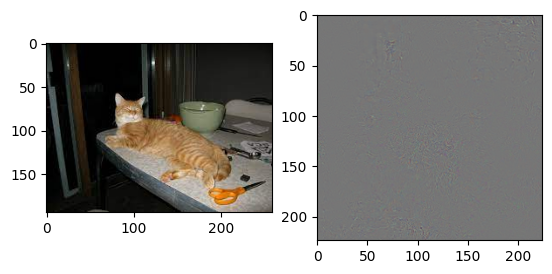

In [3]:
for i in range(1,6):
    VanillaBP(Image.open(f'imgs/i{i}.jpg'),resnet1)

**QUESTION1**
>(B)

In [4]:
# resnet => a variable representing resnet50, with default weights
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

In [5]:

# A backward hook whihc applies ReLU on its input's gradients
def backwardHook(module, inputGrad, outputGrad):
    inputGradReLU=inputGrad[0]
    inputGradReLU[inputGradReLU<0]=0
    # converting inputGradReLU to a tuple and returning it
    a=(inputGradReLU,)
    # returning 'a', whihc is a tuple
    return a

hand=[]
for name, module in resnet.named_modules():
    if isinstance(module, nn.ReLU):
        hand.append(module.register_backward_hook(backwardHook))

# guided Back Propropagation
def GuidedBP(i1,model,showPlot=True):
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    img=PreprocessIt2(i1)
    img.requires_grad = True
    
    output = model(img)
    label=getClassIndex(output[0])
    
    P=np.zeros(1000)
    P[label] = 1
    P=torch.from_numpy(P)
    
    model.zero_grad()
    output[0].backward(gradient=P)
    
    grads=img.grad
    grads=grads.reshape((3,224,224))
    gradNotNormalised=grads
    grads=grads-torch.min(grads)/(torch.max(grads)-torch.min(grads))
    grads=grads.numpy()
    grads=grads.transpose((1,2,0))
    if(showPlot):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(i1)
        plt.subplot(1, 2, 2)
        plt.imshow(grads)
    return gradNotNormalised.numpy()

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


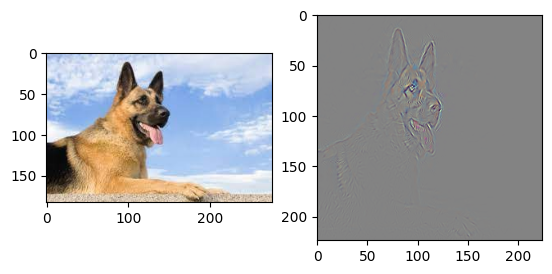

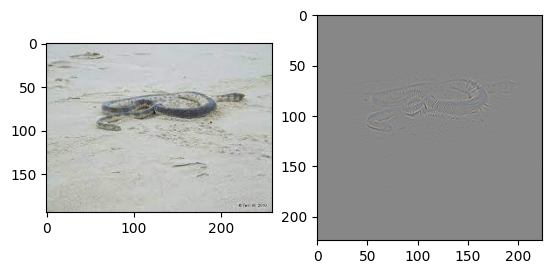

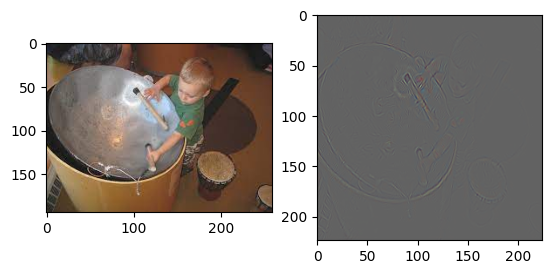

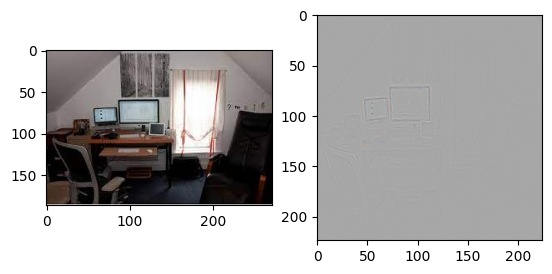

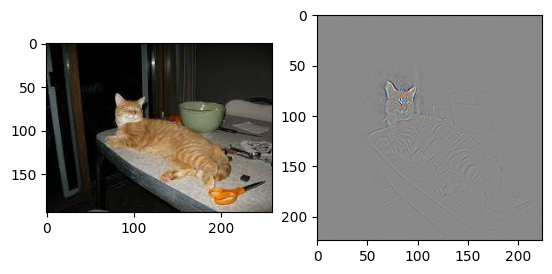

In [6]:
GuidedBPArray=[]
for i in range(1,6):
    GuidedBPArray.append(GuidedBP(Image.open(f'imgs/i{i}.jpg'),resnet))   
for i in hand:
    i.remove()

**QUESTION1**
>(C)

In [7]:
def PreprocessIt(img):
    preprocess = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    i1_new = preprocess(img)
    i1_new.requires_grad=False
    i1_new = i1_new.squeeze()
    return i1_new

In [8]:
def CAM(image,showPlot=True):
    resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in resnet.parameters():
        param.requires_grad = False
    inputImage=PreprocessIt(image)
    resnet.eval()
    outputs = resnet(inputImage.reshape((1,3,224,224)))

    label=getClassIndex(outputs[0])
   
    # resnetNew => a model which takes the input image (same as resnet50) but outputs a 1x2048x7x7 tensor (a layer before GAP ) 
    resnetNew = nn.Sequential(*list(resnet.children())[:-2])
    resnetNew.eval()
    # output of resnetNew model for the image 'inputImage'
    outputNew = resnetNew(inputImage.reshape((1,3,224,224)))
    List=list(resnet.children())
    b=List[9].weight[label]
    
    for i in b:
        i.required_grad=False
        
    outputNew=outputNew.reshape((2048,7,7))
    
    d=torch.zeros(size=(7,7))
    for i in range(0,2048):
        d=d+b[i]*outputNew[i]
    d.required_grad=False
    d=d.numpy()
    
    resized_down = cv2.resize(d,(224,224)) #, interpolation= cv2.INTER_LINEAR)
    inputImage=inputImage.numpy()
    inputImage=inputImage.transpose((1, 2, 0))
    if(showPlot):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(inputImage, cmap='gray')
        plt.imshow(resized_down, cmap='jet', alpha=0.5)
    return outputNew

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


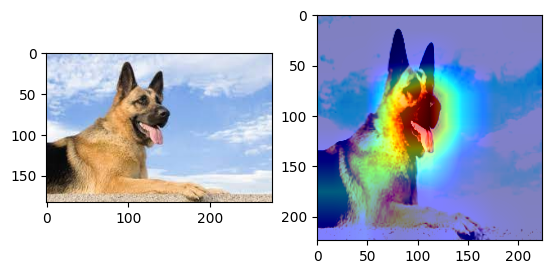

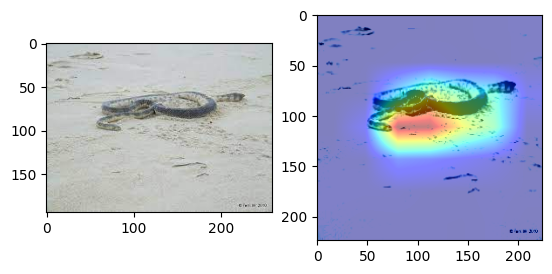

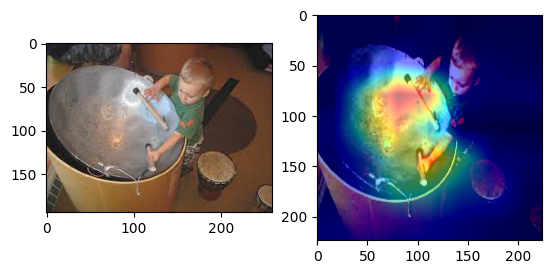

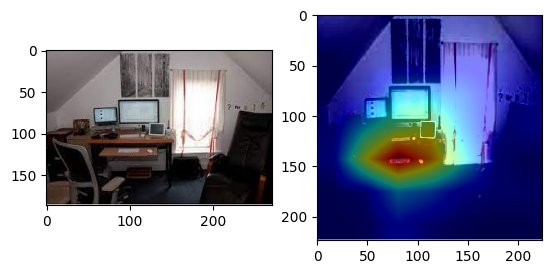

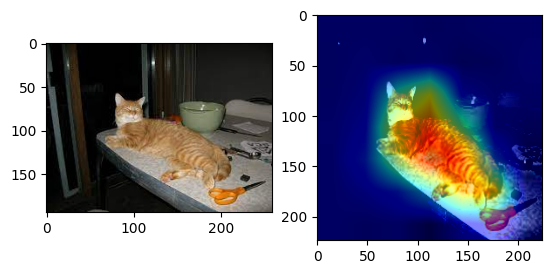

In [9]:

for i in range(1,6):
    CAM(Image.open(f'imgs/i{i}.jpg'))
    

**QUESTION1**
>(D)

In [10]:
resnet2 = resnet50(weights=ResNet50_Weights.DEFAULT)

In [11]:
# backward hook fro the gradients fo the input layer of GAP layer
def backward_hook_GAP(module, inputGrad, outputGrad):
    global GAPinputGrad
    GAPinputGrad = inputGrad[0]

# outputNew => GAP layer
outputNew = resnet2.avgpool
outputNew.register_backward_hook(backward_hook_GAP)

# This function returns the gradients of the input tensors of the GAP layer
def GuidedBPCAM(i1,model):
    for param in model.parameters():
        param.requires_grad = True
    model.eval()
    img=PreprocessIt2(i1)
    img.requires_grad = False
    
    output = model(img) 
    label=getClassIndex(output[0])
    
    P=np.zeros(1000)
    P[label] = 1
    P=torch.from_numpy(P)
    
    output[0].backward(gradient=P)
    
    grads=GAPinputGrad    
    grads=grads-torch.min(grads)/(torch.max(grads)-torch.min(grads))
    grads=grads.numpy()
    
    return grads

In [12]:
# A function which does GAP in a 2D layer(here a is 7x7 image)
def GAPIt(a):
    gap=0
    for i in range(0,a.shape[0]):
        for j in range(0,a.shape[1]):
            gap+=a[i][j]
    return gap/7*7
    
# apply GAP for the tensor 'a' (we apply GAPIt for the 2D matrices in 'a') and return the output
def applyGAP(a):
    b=[]
    for i in range(0,a.shape[1]):
        b.append(GAPIt(a[0][i]))
#     b=(b-min(b))/(max(b)-min(b))
    return b

# Multiplies alphaArray and Q and returns 7x7 image
def Mul_Alpha_ActMap(a,Q):
    s =Q.reshape((2048,7,7))
    d=torch.zeros(size=(7,7))
    for i in range(0,2048):
        d=d+a[i]*s[i]
    return d


In [13]:

def GradCAM(image):
    # Q => has the gradients of the inputs to the GAP Layer (average pool)
    Q=GuidedBPCAM(image,resnet2)
    # A list whihc has the GAP values for Q
    alphaArray=applyGAP(Q)
    return alphaArray


In [14]:
def Relu2D(a):
    for i in range(0,a.shape[0]):
        for j in range(0,a.shape[1]):
            if(a[i][j]<0): a[i][j]=0
    return a;
# Image.open('imgs/i1.jpg') => image
def GuidedGradProp(image,i,showPlot=True):
    CAM_image=CAM(image,showPlot=False)
    final_image=Mul_Alpha_ActMap(GradCAM(image),CAM_image)
    ReLU_GradCAM=Relu2D(final_image).numpy()
# hand=[]
# for  module in resnet.named_modules():
#     if isinstance(module, nn.ReLU):
#         hand.append(module.register_backward_hook(backwardHook))

# resnet3 = resnet50(weights=ResNet50_Weights.DEFAULT)
    resized_ReLU_GradCAM= cv2.resize(ReLU_GradCAM,(224,224)) #, interpolation= cv2.INTER_LINEAR)
    GuidedBPImg=GuidedBPArray[i]
    z3=np.zeros((224,224))

# print(type(z2))
# for i in range(0,224):
#     for j in range(0,224):
#         z3[i][j]=z1[i][j]*z1[i][j]

# for i in hand:
#     i.remove()
# # print(z2.shape)
# print(z2.shape)
# print(z1.shape)
# plt.imshow(z3)GuidedBPImg
# z2=z2.transpose((2, 1, 0))
# print(z2.shape)

    GuidedGradCAM=GuidedBPImg*resized_ReLU_GradCAM
    GuidedGradCAM=GuidedGradCAM.transpose((1, 2, 0))
# print(z5)
    NormalisedGuidedGradCAM=(GuidedGradCAM-np.min(GuidedGradCAM))/(np.max(GuidedGradCAM)-np.min(GuidedGradCAM))
    if(showPlot):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(image, cmap='gray')
        plt.imshow(NormalisedGuidedGradCAM)


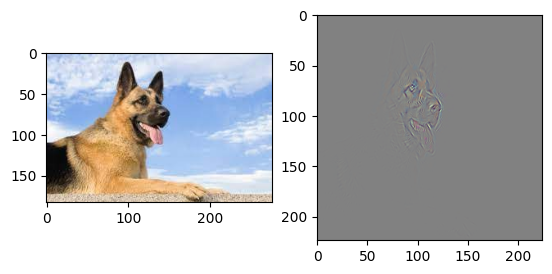

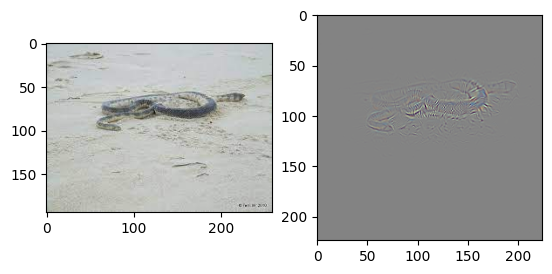

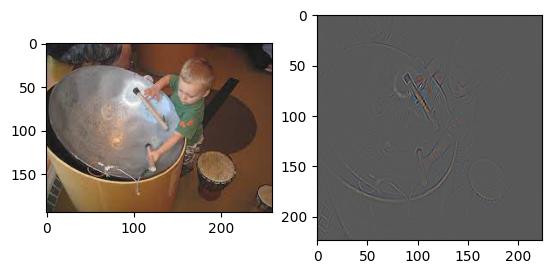

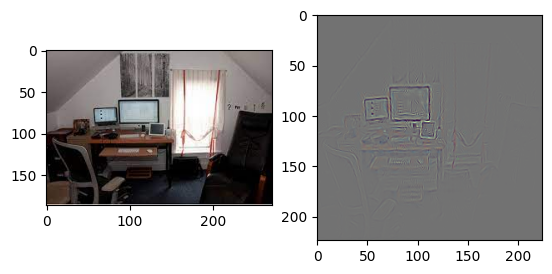

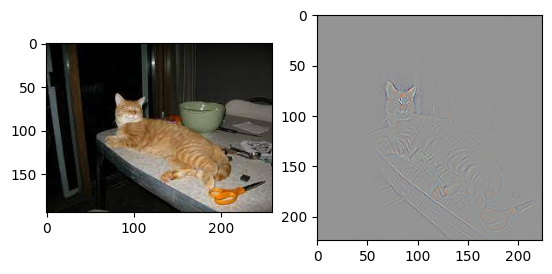

In [15]:
for i in range(1,6):
        GuidedGradProp(Image.open(f'imgs/i{i}.jpg'),i-1)

**QUESTION 2**

**Importing Libraries Required For 2nd Question**

In [16]:
import imageio.v2
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import imageio as img
from matplotlib import cm
import math as m

Converting(sympifying) x,y to variables on which sympy.diff and other sympy operations can be done

In [17]:
x=sy.sympify('x')
y=sy.sympify('y')
# func is the given function
func=10*(x**2)+y**2

A method which takes a function 'f' and a point X as parameters, and returns the gradient of f at X


In [18]:
def grad(f,X):
    gradX=sy.diff(func,x).evalf(subs={x:X[0],y:X[1]})
    gradY=sy.diff(func,y).evalf(subs={x:X[0],y:X[1]})
    return np.array([gradX,gradY])


**Vanilla SGD**

In [19]:
# A function which updates the point in the Vanilla SGD 
def VanillaSGDUpdate(f,X,alpha=0.02):
    X_new=np.subtract(X,alpha*grad(f,X))
    return X_new

# A function whihc performs VanillaSGD
def VanillaSGD(func,X_0,MaxNumberOfIterations=50):
    # VanillaPoints => points of the X after every iteration of vanilla SGD
    VanillaPoints = []
    for i in range(0,MaxNumberOfIterations):
        VanillaPoints.append(X_0)
        X_0 = VanillaSGDUpdate(func,X_0)
    return X_0,VanillaPoints

**SGD With Momentum**

In [38]:
# A function does the update in SGD with momentum method
def SGDWithMomentumUpdate(f,X,V,alphaW=0.01,alphaV=0.1):
    V_new = np.add(alphaV*V,grad(f,X))
    X_new = np.subtract(X,alphaW*V_new)
    return X_new,V_new

# A function which does the SGD with momentum 
def SGDWithMomentum(func,X_0,V_0=np.array([0.0,0.0]),MaxNumberOfIterations=50,alphaW=0.1,alphaV=0.1):
    SGDWithMomentumPoints = []
    for i in range(0,MaxNumberOfIterations):
        SGDWithMomentumPoints.append(X_0)
        X_0,V_0=SGDWithMomentumUpdate(func,X_0,V_0,alphaW=0.01,alphaV=0.1)
    return X_0,SGDWithMomentumPoints



**Nesterov Momentum**

In [39]:
# A function does the update in Nesterov Momentum  method
def NesterovMomentumUpdate(f,X,V,alphaW=0.05,alphaV=0.001):
    V_new = np.add(alphaV*V,grad(f,np.add(X,alphaV*V)))
    X_new = np.subtract(X,alphaW*V_new)
    return X_new,V_new

# A function which does the Nesterov Momentum
def NesterovMomentum(func,X_0,V_0=np.array([0.0,0.0]),MaxNumberOfIterations=50,alphaW=0.05,alphaV=0.01):
    NesterovMomentumPoints = []
    for i in range(0,MaxNumberOfIterations):
        NesterovMomentumPoints.append(X_0)
        X_0,V_0=NesterovMomentumUpdate(func,X_0,V_0,alphaW=0.05,alphaV=0.001)
    return X_0,NesterovMomentumPoints

**AdaGrad**

In [40]:
# A function does the update in AdaGrad method
def AdaGradUpdate(f,X,grad_sq,alpha=5,epsilon=1):
    gradNew=grad(f,X)
    grad_sq+=np.dot(gradNew,gradNew)
    X_new=np.subtract(X,alpha*gradNew/(m.sqrt(grad_sq)+epsilon))
    return X_new,grad_sq

# A function which does the AdaGrad
def AdaGrad(func,X_0,grad_sq=0,MaxNumberOfIterations=50,alpha=5,epsilon=1):
    AdaGradPoints = []
    for i in range(0,MaxNumberOfIterations):
        AdaGradPoints.append(X_0)
        X_0,grad_sq=AdaGradUpdate(func,X_0,grad_sq,alpha=5,epsilon=1)
    return X_0,AdaGradPoints

**RMSProp**

In [41]:
# A function does the update in RMSProp method
def RMSPropUpdate(f,X,grad_sq,alpha=0.5,epsilon=0.5,rho=0.5):
    gradNew=grad(f,X)
    grad_sq=rho*grad_sq+(1-rho)*np.dot(gradNew,gradNew)
    X_new=np.subtract(X,alpha*gradNew/(m.sqrt(grad_sq)+epsilon))
    return X_new,grad_sq

# A function which does the RMSProp
def RMSProp(func,X_0,grad_sq=0,MaxNumberOfIterations=50,alpha=0.5,epsilon=0.5,rho=0.5):
    RMSPropPoints=[]
    for i in range(0,MaxNumberOfIterations):
        RMSPropPoints.append(X_0)
        X_0,grad_sq=RMSPropUpdate(func,X_0,grad_sq,alpha=0.5,epsilon=0.5,rho=0.5)
    return X_0,RMSPropPoints

**Calculation**

In [42]:
X_0=np.array([5,5])

VanillaPoints= np.arange(100).reshape(50,2)
a,VanillaPoints=VanillaSGD(10*(x**2)+y**2,X_0)
VanillaPoints=np.array(VanillaPoints)
print(f'The final point after 50 iterations using Vanilla SGD is {a}')


b,SGDWithMomentumPoints=SGDWithMomentum(10*(x**2)+y**2,X_0,alphaW=.05,alphaV=1)
SGDWithMomentumPoints=np.array(SGDWithMomentumPoints)
print(f'The final point after 50 iterations using SGD with momentum is {b}')

c,NesterovMomentumPoints=NesterovMomentum(10*(x**2)+y**2,X_0)
NesterovMomentumPoints=np.array(NesterovMomentumPoints)
print(f'The final point after 50 iterations using Nesterov Momentum is {c}')

d,AdaGradPoints=AdaGrad(10*(x**2)+y**2,X_0)
AdaGradPoints=np.array(AdaGradPoints)
print(f'The final point after 50 iterations using AdaGrad is {d}')

e,RMSPropPoints=RMSProp(10*(x**2)+y**2,X_0)
RMSPropPoints=np.array(RMSPropPoints)
print(f'The final point after 50 iterations using RMSProp is {e}')

The final point after 50 iterations using Vanilla SGD is [4.04140638732382e-11 0.649428967610193]
The final point after 50 iterations using SGD with momentum is [1.11607982350144e-5 1.62500375456673]
The final point after 50 iterations using Nesterov Momentum is [5.21988275538949e-42 0.0253036781427145]
The final point after 50 iterations using AdaGrad is [3.02890738447672e-74 0.0309765308170632]
The final point after 50 iterations using RMSProp is [0.225032633653106 2.61380045357929e-5]


**Vectorize the given function**

In [43]:
def feval(x,y):
    return 10*(x**2)+y**2
Vfeval=np.vectorize(feval)

**Save the points**

In [44]:
def f(x,y):
    return 10*(x)**2+y**2
def plotF():
    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    ax = plt.axes()
    ax.contourf(X, Y, Z,alpha=0.8)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [45]:
!mkdir images

A subdirectory or file images already exists.


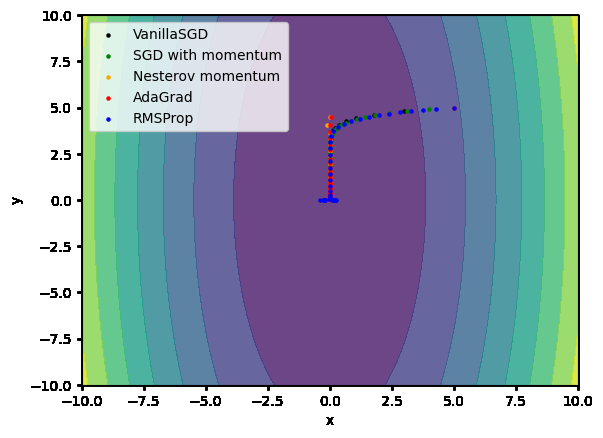

In [46]:
for i in range(1,51):
    plotF()
    plt.scatter(VanillaPoints[0:i,0:1],VanillaPoints[0:i,1:2],s=5,c='k',label='VanillaSGD')
    plt.scatter(SGDWithMomentumPoints[0:i,0:1],SGDWithMomentumPoints[0:i,1:2],s=5,c='green',label='SGD with momentum')
    plt.scatter(NesterovMomentumPoints[0:i,0:1],NesterovMomentumPoints[0:i,1:2],s=5,c='orange',label='Nesterov momentum')
    plt.scatter(AdaGradPoints[0:i,0:1],AdaGradPoints[0:i,1:2],s=5,c='red',label='AdaGrad')
    plt.scatter(RMSPropPoints[0:i,0:1],RMSPropPoints[0:i,1:2],s=5,c='blue',label='RMSProp')
    plt.legend()
    plt.xlim((-10,10))
    plt.savefig('images/'+str(i))
                

In [47]:
# print(VanillaPoints[0:1,0:1],VanillaPoints[0:1,1:2])
# print(SGDWithMomentumPoints[0:1,0:1],SGDWithMomentumPoints[0:1,1:2])
# print(NesterovMomentumPoints[0:1,0:1],NesterovMomentumPoints[0:1,1:2])
# print(AdaGradPoints[0:1,0:1],AdaGradPoints[0:1,1:2])
# print(RMSPropPoints[0:1,0:1],RMSPropPoints[0:1,1:2])

**Converting to GIF**

In [48]:
images = []
for i in range(1,51):
    images.append(imageio.v2.imread('images/'+str(i)+'.png'))
imageio.mimsave('sgd_update_rules.gif', images)